In [6]:
using Revise
push!(LOAD_PATH,"../src/")
using ProgressBars
using Random
using ITensors,ITensorMPS
using PastaQ
using RandomMeas

In [7]:
#Perform RM in the first experiment
N = 8
ξ = siteinds("Qubit", N)

p,dp = 0.15,0.02
p_vec = [max(0, min(p + dp * randn(), 1)) for i in 1:N]
G = 1 .-p_vec/2

circuit = randomcircuit(N, depth=2)
states = ["Dn" for n in 1:N]
ψ0  = MPS(ComplexF64,ξ,states)

ρ0 = outer(ψ0',ψ0)
ρ0n = copy(ρ0)
Apply_depo_channel!(ρ0n,ξ,p_vec)

#
ρ = runcircuit(ρ0,circuit)
ρn = copy(ρ)
Apply_depo_channel!(ρn,ξ,p_vec)
#ρ = runcircuit(circuit;noise = noisemodel);
println("state prepared in the `experiment' 1 ")
#RM on a calibration state


nu=100 #Number of random unitaries
NM=10000 #Number of projective measurements per unitary

state prepared in the `experiment' 1 


10000

In [8]:
#Calibration experiment
Gs = zeros(Float64,N)
for r in ProgressBar(1:nu, printing_delay=2)
        u = get_rotations(ξ,1) #Haar rotations in A
        data = get_RandomMeas(ρ0n,u,NM)
        σu = apply(u,ρ0,apply_dag=true)
        #σu = rotate(ρ0,u)
        for i in 1:N
            P = get_Born(data[:,i:i],ξ[i:i])
            #P2 = get_Born_data_binary(datat2[:,i:i],ξ[i:i])
            #@show norm(P-P2)
            σui,ξi = reduce_dm(σu,collect(i:i))
            Pσ = get_Born(σui)
            Gs[i] += real((3*(P-Pσ)*Pσ)[]+1)/nu
            #Gs[i] += real((3*(P-Pσ)*Pσ)[]+1)/nu
        end
end
println(G)
println(Gs)

0.0%┣                                              ┫ 0/100 [00:00<00:00, -0s/it]
92.0%┣████████████████████████████████████████▌   ┫ 92/100 [00:02<00:00, 45it/s]


[0.9187606944295327, 0.9276152223657846, 0.9133762696604503, 0.9158065414071859, 0.9282457584960316, 0.9279647841511441, 0.910917394339781, 0.9368791872567804]
[0.9117426613378256, 0.9158168530550913, 0.9084456001325482, 0.9123205697664782, 0.9192423171599582, 0.9236501808985242, 0.9135865089189679, 0.9436992350452215]


100.0%┣██████████████████████████████████████████┫ 100/100 [00:02<00:00, 45it/s]
100.0%┣██████████████████████████████████████████┫ 100/100 [00:02<00:00, 45it/s]


In [13]:
u = Vector{Vector{ITensor}}()
data = zeros(Int8,nu,NM,N)
for r in ProgressBar(1:nu, printing_delay=2)
            push!(u,get_rotations(ξ,1)) #generate random unitary
            data[r,:,:] = get_RandomMeas(ρn,u[r],NM) #data acquisation in simulated quantum device
end

0.0%┣                                              ┫ 0/100 [00:00<00:00, -0s/it]
100.0%┣██████████████████████████████████████████┫ 100/100 [00:01<00:00, 70it/s]
100.0%┣██████████████████████████████████████████┫ 100/100 [00:01<00:00, 70it/s]


In [14]:
ITensors.disable_warn_order()
purity = zeros(Float64,N)
purity_nonmit = zeros(Float64,N)
purity_mit = zeros(Float64,N)

for NA in ProgressBar(1:N, printing_delay=2)
        purity[NA] = get_purity(ρ,collect(1:NA),ξ)
        uA = [ut[1:NA] for ut in u]
        purity_nonmit[NA] = get_purity_shadows(data[:,:,1:NA],uA,ξ[1:NA])
        purity_mit[NA] = get_purity_shadows(data[:,:,1:NA],uA,ξ[1:NA];G=Gs)

end

0.0%┣                                                ┫ 0/8 [00:00<00:00, -0s/it]
25.0%┣████████████                                    ┫ 2/8 [00:09<00:51, 9s/it]
37.5%┣█████████████████▋                             ┫ 3/8 [00:22<00:54, 11s/it]
50.0%┣███████████████████████▌                       ┫ 4/8 [00:41<00:54, 14s/it]
62.5%┣█████████████████████████████▍                 ┫ 5/8 [01:01<00:46, 15s/it]
75.0%┣███████████████████████████████████▎           ┫ 6/8 [01:25<00:34, 17s/it]
87.5%┣█████████████████████████████████████████▏     ┫ 7/8 [01:54<00:19, 19s/it]
100.0%┣██████████████████████████████████████████████┫ 8/8 [02:27<00:00, 21s/it]
100.0%┣██████████████████████████████████████████████┫ 8/8 [02:27<00:00, 21s/it]


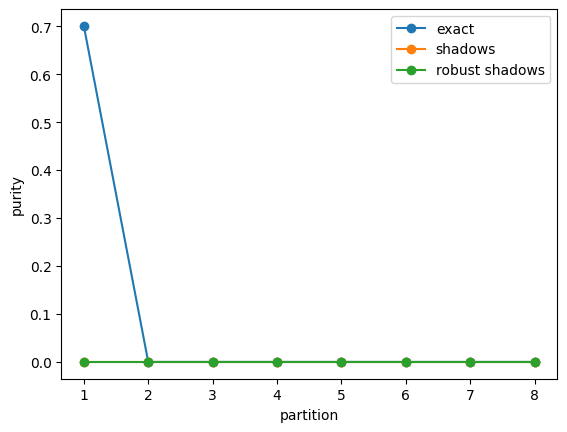

PyObject <matplotlib.legend.Legend object at 0x7f49a40c98d0>

In [11]:
using PyPlot
plot(1:N,purity,"-o")
plot(1:N,purity_nonmit,"-o")
plot(1:N,purity_mit,"-o")
xlabel("partition")
ylabel("purity")
legend(["exact","shadows","robust shadows"])